In [1]:
# Importing necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from time import time 

from sklearn.model_selection import train_test_split, GridSearchCV, LeaveOneOut
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.neural_network import MLPRegressor

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

sns.set(font_scale=1.5)

In [3]:
# Read data from 'resd_features.csv'
data = pd.read_csv('../input/resd_features.csv')

In [4]:
data.head()

,surface,n_bhk,sa1,pool,sa9,sa7,sa2,sa5,price
0,-1.069848,1.0,0,1,0,0,1,0,3.9
1,-0.318089,2.0,0,1,0,0,1,0,6.5
2,-0.011520,3.0,0,1,0,0,1,0,7.4
3,0.332370,3.0,0,1,0,0,1,0,8.9
4,-0.400729,2.0,0,1,0,0,0,0,7.4


In [5]:
# Separate the features (X) and target (y) from the dataset
X = data.iloc[:, :-1] 
y = data["price"]     


---

## MLPRegression with scikit-learn

In [6]:
def gridSearchReport(estimator, X, y, pg, cv=LeaveOneOut(), rs=118):
    """
    Performs grid search and cross-validation for the given regressor.

    Parameters:
        estimator: The regressor
        X: Pandas DataFrame, feature data
        y: Pandas Series, target
        pg: Dictionary, parameters' grid
        cv: Cross-validation generator or an iterable
        rs: Random state for the training-test split

    Returns:
        est_cv: The trained estimator with the best parameters
    """

    t0 = time()

    X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size=0.3, random_state=rs)

    est_cv = GridSearchCV(
        estimator,
        param_grid=pg,
        scoring="neg_mean_squared_error",
        n_jobs=-1,
        cv=cv
    )

    est_cv.fit(X_train, y_train)

    print("Best parameters:", est_cv.best_params_)
    print("Best CV score:", abs(est_cv.best_score_))
    y_train_pred, y_test_pred = est_cv.predict(X_train), est_cv.predict(X_test)
    print("MSE, R2 train:", mean_squared_error(y_train, y_train_pred), ", ", r2_score(y_train, y_train_pred))
    print("MSE, R2 test:", mean_squared_error(y_test, y_test_pred), ", ", r2_score(y_test, y_test_pred))

    t = round(time() - t0, 2)
    print("Elapsed time:", t, "s,", round(t / 60, 2), "min")

    return est_cv


In [7]:
def plotResidue(estimator, X, y, rs=118):
    """
    Plots the fit residuals (price - predicted_price) vs. the "surface" variable.

    Parameters:
        estimator: GridSearchCV, the regressor
        X: Pandas DataFrame, feature data
        y: Pandas Series, target
        rs: int, random state
    """
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=rs)

    residue_train = y_train.values.reshape(-1, 1) - estimator.predict(X_train.values).reshape(-1, 1)
    residue_test = y_test.values.reshape(-1, 1) - estimator.predict(X_test.values).reshape(-1, 1)

    fig, axe = plt.subplots(1, 2, figsize=(18, 10))
    axe[0].scatter(X_train["surface"], residue_train, label="train")
    axe[0].scatter(X_test["surface"], residue_test, label="test")
    axe[0].plot([-2.3, 4.5], [0, 0], "black")
    axe[0].set_xlabel("Scaled surface")
    axe[0].set_ylabel("Fit residuals")
    axe[0].legend()

    axe[1].hist(residue_test, bins=25)
    axe[1].set_xlabel("Fit residuals for test set")
    axe[1].set_ylabel("Count")

    plt.show()

    print("mean residuals:", round(np.mean(residue_test), 2),
          "\nstd:", round(np.std(residue_test), 2))


In [8]:
# Set the random seed
rs = 10

# Create an MLPRegressor with specific hyperparameters

mlpReg = MLPRegressor(
    activation='relu',  # Activation function for hidden layers
    solver='adam',      # Solver for weight optimization
    learning_rate_init=0.001,  # Initial learning rate
    max_iter=500,       # Maximum number of iterations for training
    early_stopping=True,  # Enable early stopping to prevent overfitting
    validation_fraction=0.1,  # Fraction of training data to use for validation
    n_iter_no_change=30,     # Number of iterations with no improvement to wait
    tol=1e-4,             # Tolerance to declare convergence
    random_state=rs       # Random state for reproducibility
)

# Define a parameter grid for grid search
pg = {
    "hidden_layer_sizes": [(10,), (20,), (10, 5), (20, 10)],  # Varying hidden layer sizes
    "learning_rate": ['constant', 'invscaling', 'adaptive'],  # Varying learning rate schedules
    "alpha": np.logspace(-3, 3, 5),  # Varying regularization strength
    "batch_size": [8, 16, 32, 64]   # Varying batch sizes for training
}

# Perform grid search and cross-validation with 5-fold cross-validation and the specified random state
mlpReg_cv = gridSearchReport(mlpReg, X, y, pg, cv=5, rs=rs)


Best parameters: {'alpha': 0.03162277660168379, 'batch_size': 16, 'hidden_layer_sizes': (10,), 'learning_rate': 'constant'}
Best CV score: 10.817372772983287
MSE, R2 train: 19.32218400198936 ,  0.5593148459873337
MSE, R2 test: 3.875905475325513 ,  0.522233069042502
Elapsed time: 114.62 s , 1.91 min


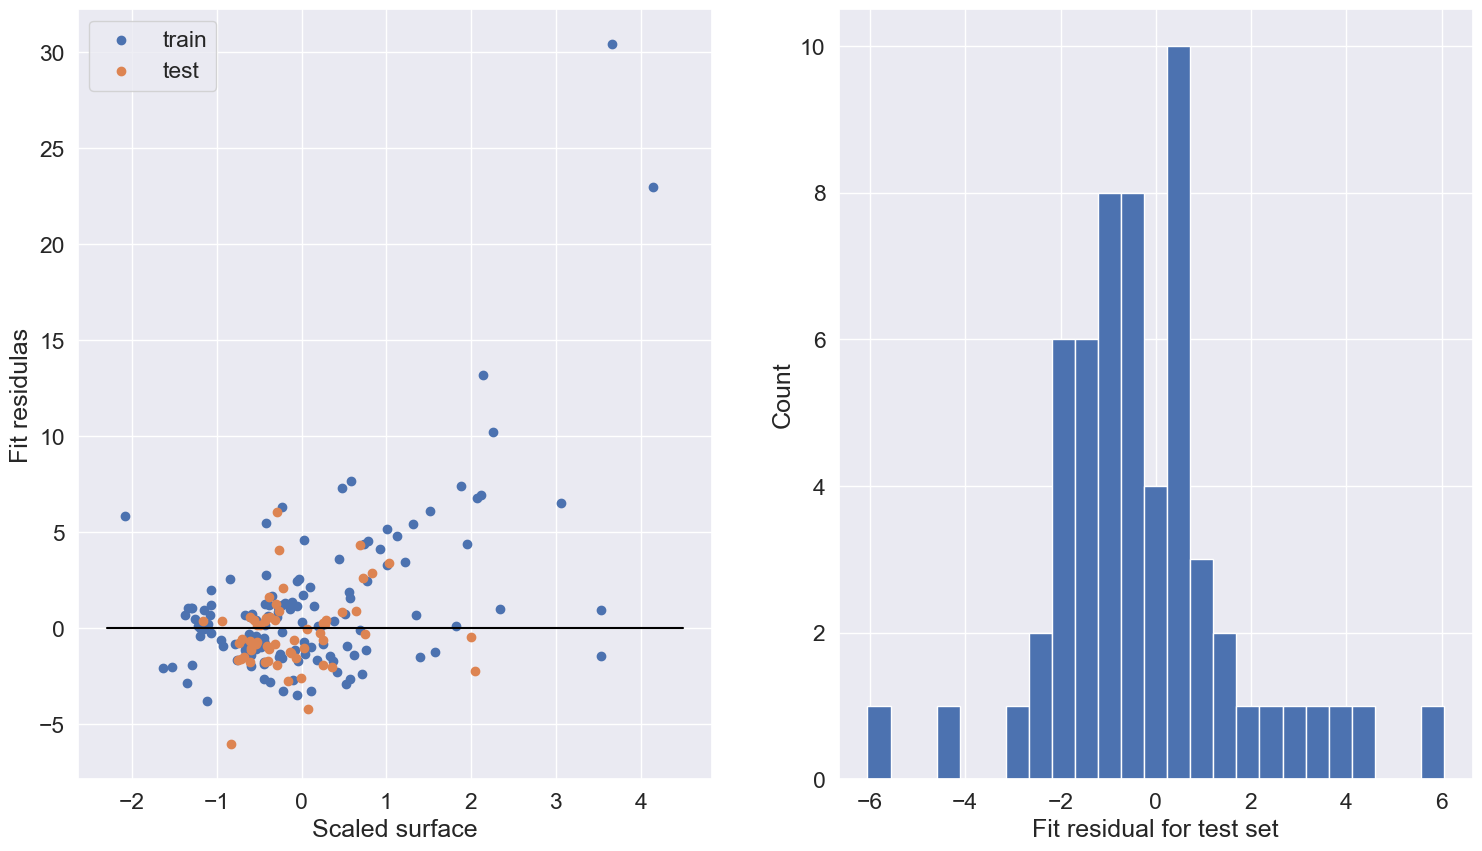

mean residuals: -0.24 
std: 1.95


In [9]:
# Visualize residuals for MLPRegressor
plotResidue(mlpReg_cv, X, y, rs=rs)


In [10]:
def plot_real_pred(est, X, y, rs):
    """
    Plot the real price vs. predicted price using a regressor.

    Parameters:
        est: Regressor
        X: Pandas DataFrame, feature data
        y: Pandas Series, target
        rs: int, random state
    """    
    X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size=0.3, random_state=rs)
    
    fig = plt.figure(figsize=(7, 7))
    plt.scatter(y_test, est.predict(X_test))
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], c="k")
    plt.xlabel("Real price")
    plt.ylabel("Predicted price")
    plt.show()


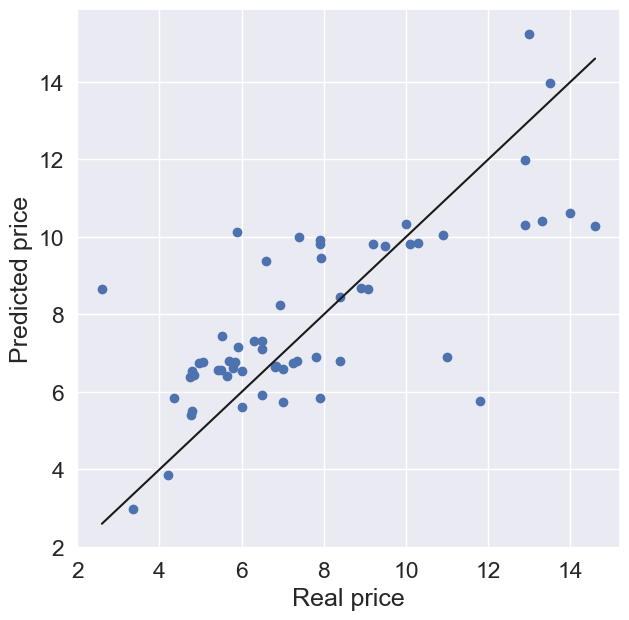

In [11]:
# Visualize real vs. predicted prices with MLPRegressor
plot_real_pred(mlpReg_cv, X, y, rs)


---

## Regression with Tensor Flow

In [12]:
# Min-max normalize 'y' for use with tanh activation
R = np.max(y) - np.min(y)
y0 = np.min(y)
y_scaled = 2 * (y - y0) / R - 1


In [13]:
def y2price(y, R):
    """
    Convert the scaled price to normal price
    Args:
    y: list, serie, array
        scaled price
    R: float
        scale factor
    """
    return y #R*(y+1)/2.+y0

In [14]:
rs=13

# Split data into training and testing sets with a random state of 13
X_train, X_test, y_train, y_test = train_test_split(X.values, y_scaled.values, test_size= 0.3, random_state= rs)


In [15]:
# Define a TensorFlow (TF) model template with a dense hidden layer and an output layer.
def tf_template():
    model = tf.keras.models.Sequential()
    
    # Dense hidden layer with 20 units and ReLU activation
    model.add(tf.keras.layers.Dense(20, activation='relu'))
    
    # Dropout layer to prevent overfitting
    model.add(tf.keras.layers.Dropout(0.2))
    
    # Output layer with 1 unit and tanh activation
    model.add(tf.keras.layers.Dense(1, activation='tanh'))
    
    return model


In [16]:
# Building a TensorFlow (TF) model, compiling it, and training with early stopping

tf_model = tf_template()  # Build a TF model using the defined template

# Compile the TF model with mean squared error loss and Adam optimizer
tf_model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(), metrics=['mse', 'mae'])

# Set up early stopping callback to prevent overfitting
callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=1.e-4,
    patience=20,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=True
)

# Train the TF model with specified number of epochs, batch size, and validation data
n_epochs = 500
batch_size = 8
tf_model.fit(X_train, y_train, callbacks=[callback],
             epochs=n_epochs, batch_size=batch_size,
             validation_data=(X_test, y_test),
             verbose=0, shuffle=True)


In [17]:
# Display a summary of the TensorFlow (TF) model architecture
tf_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 20)                180       
                                                                 
 dropout (Dropout)           (None, 20)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 21        
                                                                 
Total params: 201
Trainable params: 201
Non-trainable params: 0
_________________________________________________________________


In [18]:
# Retrieve the keys of training history data for the TensorFlow (TF) model
tf_model.history.history.keys()


dict_keys(['loss', 'mse', 'mae', 'val_loss', 'val_mse', 'val_mae'])

In [19]:
def plot_model_history(history):
    '''Plot the training and validation history for a TensorFlow network.
    
    Args:
        history (tf.keras.callbacks.History): The training history of a TF model.
    '''
    
    # Extract loss and accuracy from the training history
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    acc = history.history['mae']
    val_acc = history.history['val_mae']
    
    # Create subplots for loss and accuracy
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
    
    # Plot loss curves
    ax[0].plot(np.arange(len(loss)), loss, label='Training')
    ax[0].plot(np.arange(len(val_loss)), val_loss, label='Validation')
    ax[0].set_title('Mean Square Error')
    ax[0].legend()
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')

    # Plot Mean Absolute Error (MAE) curves
    ax[1].plot(np.arange(len(acc)), acc, label='Training')
    ax[1].plot(np.arange(len(acc)), val_acc, label='Validation')
    ax[1].set_title('Mean Absolute Error Curves')
    ax[1].legend()
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Mean Absolute Error')


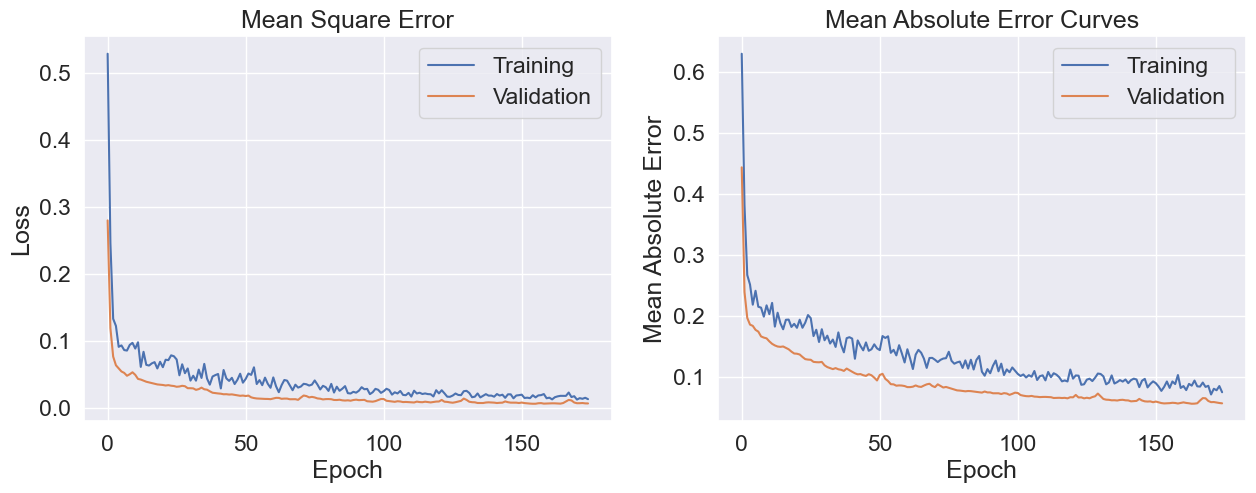

In [20]:
# Plot the training history of the TensorFlow (TF) model
plot_model_history(tf_model.history)


2/2 [==============================] - 0s 3ms/step


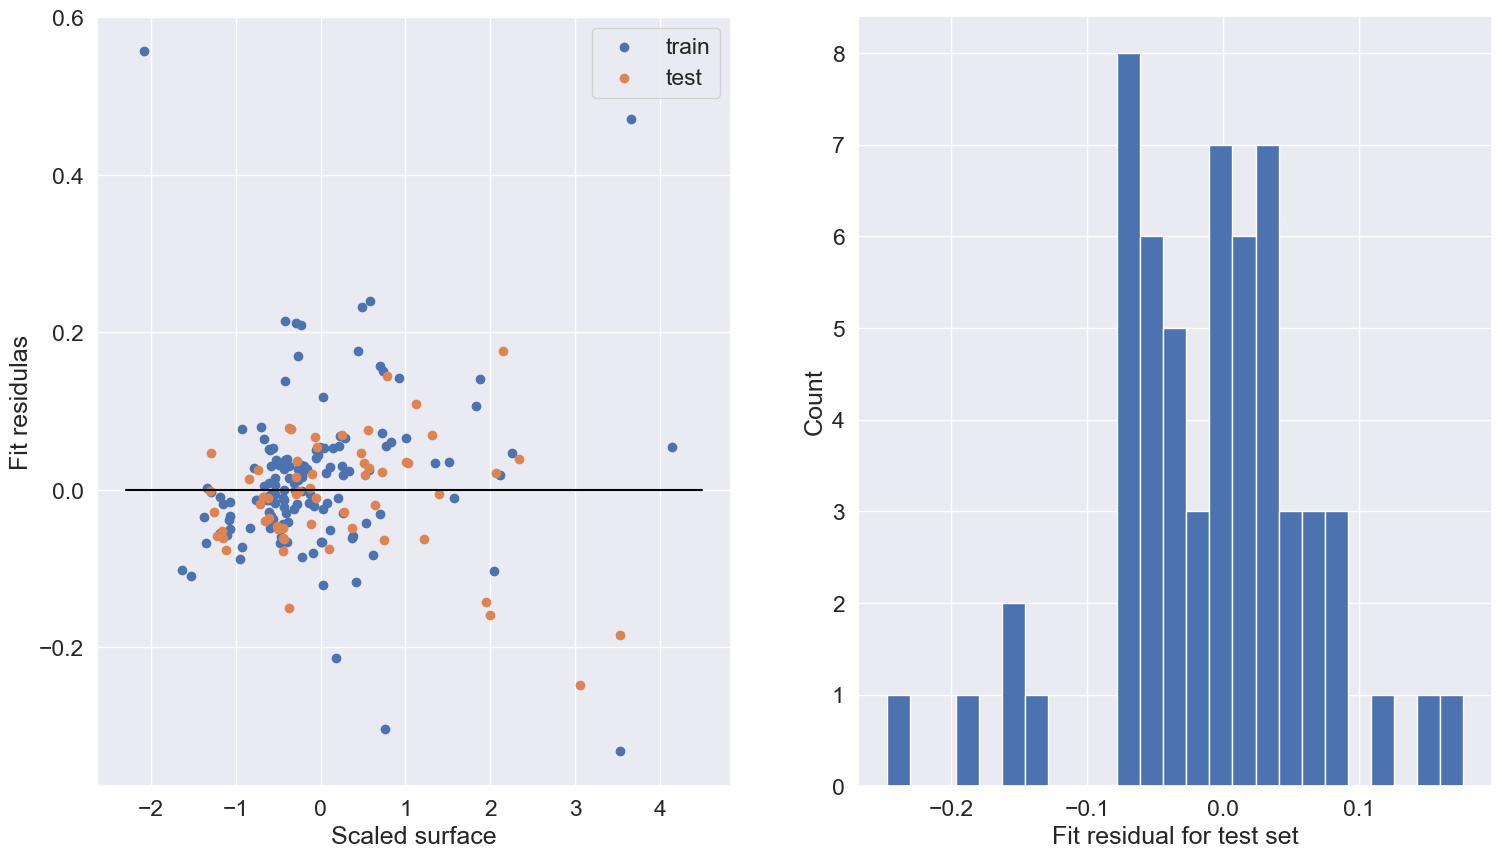

mean residuals: -0.01 
std: 0.07


In [21]:
# Plot the residuals of the TensorFlow (TF) model predictions
plotResidue(tf_model, X, y_scaled, rs=rs)


2/2 [==============================] - 0s 0s/step


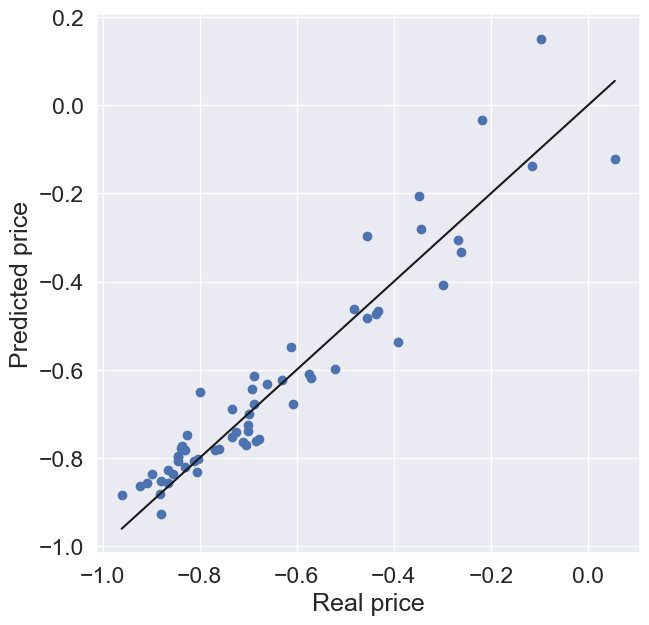

In [22]:
# Plot real vs. predicted values
plot_real_pred(tf_model, X, y_scaled, rs)


In [23]:
# Calculate R-squared, mean squared error, and mean absolute error for training data
(y2price(y_train, R), y2price(y_train_pred, R)), 
(mean_squared_error(y2price(y_train, R), y2price(y_train_pred, R)),
mean_absolute_error(y2price(y_train, R), y2price(y_train_pred, R)))


5/5 [==============================] - 0s 0s/step


(0.8512462063814145, 0.010772297546298841, 0.06434002891012972)

In [24]:
# Calculate R-squared, mean squared error, and mean absolute error for test data
(r2_score(y2price(y_test, R), y2price(y_pred, R)), 
mean_squared_error(y2price(y_test, R), y2price(y_pred, R)),
mean_absolute_error(y2price(y_test, R), y2price(y_pred, R)))


2/2 [==============================] - 0s 2ms/step


(0.8952097441221157, 0.005710700117263729, 0.05675723906438039)

---